# Introduction

Data Cleaning / quick EDA

# Setup

In [184]:
# Enable autoreload for Python modules (e.g., scripts in the utils folder)
%load_ext autoreload
%autoreload 2

# === Standard Library Imports ===
from datetime import datetime, timedelta
import json
import numpy as np
import os
import sys
from pathlib import Path
import random

# === Third-Party Library Imports ===
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
from scipy.stats import f_oneway
import seaborn as sns

# === Local Project-Specific Imports ===
# Add project root to the Python path
root_path = os.path.abspath("../")
if root_path not in sys.path:
    sys.path.append(root_path)

from src.utils import load_yaml, to_snake_case, clean_column_names, Timer

# Load environment variables from .env
from dotenv import load_dotenv
load_dotenv();

# Configure display options
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', 20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
# Start timer
timer = Timer()

# Load config

In [186]:
config = load_yaml("../config/data.yaml")

print(json.dumps(config, indent=4))

{
    "base_path": "../",
    "paths": {
        "raw_data": "data/00_raw/",
        "clean_data": "data/01_clean/",
        "output_data": "data/02_output/",
        "other_data": "data/99_other/",
        "simulation_results": "data/03_simulation/",
        "reports": "reports/",
        "logs": "logs/"
    },
    "logging": {
        "level": "INFO",
        "path": "logs/app.log"
    },
    "data": {
        "raw": {
            "path": "Quant_Take_Home.xlsx",
            "sheet": "Pipeline Data",
            "columns": {
                "Business Unit": "str",
                "Account Name": "str",
                "Opportunity Number": "int64",
                "Forecast Category": "str",
                "Award Date": "datetime64[ns]",
                "Revenue Amount": "float64",
                "Stage": "str",
                "Probability of Award": "float64",
                "Weighted Revenue Amount": "float64",
                "Type": "str",
                "Revenue Type": "str"

# Pull data

In [187]:
# Build full path to the Excel file
base_path = Path(config["base_path"])
raw_data_path = base_path / config["paths"]["raw_data"]
excel_file = raw_data_path / config["data"]["raw"]["path"]
sheet_name = config["data"]["raw"]["sheet"]
print("Excel file:", excel_file)
print("Sheet name:", sheet_name)

# === Load Excel sheet ===
df = pd.read_excel(excel_file, sheet_name=sheet_name)
print(df.shape)

df.head()

Excel file: ../data/00_raw/Quant_Take_Home.xlsx
Sheet name: Pipeline Data
(1310, 12)


,Business Unit,Account Name,Opportunity Number,Forecast Category,Award Date,Revenue Amount,Stage,Probability of Award,Weighted Revenue Amount,Type,Revenue Type,Revenue Year
0,Maritime,Prometheus Defense Innovations,71201,Base Case,2029-08-25 00:00:00,195836453,Shaping,0.9023,1.767032e+08,Follow-On,O&M,2029
1,Radars,Inferno Protection Tech,31305,Base Case,2029-11-04 00:00:00,114991405,Shaping,0.9023,1.037567e+08,New Business,Product,2029
2,Solid Rocket Motors,Vortex Security Dynamics,30977,Base Case,2029-11-29 00:00:00,151129327,Shaping,0.9023,1.363640e+08,New Business,O&M,2029
3,Command and Control,Maelstrom Defense Group,75064,Base Case,2029-02-20 00:00:00,195003733,Shaping,0.7725,1.506404e+08,Follow-On,Product,2029
4,Command and Control,Vanguard Tactical Solutions,32256,Base Case,12/14/2029,23139092,Shaping,0.2430,5.622799e+06,New Business,Development,2029


# Quick Checks

In [188]:
print(df.columns)

Index(['Business Unit ', 'Account Name', 'Opportunity Number ',
       'Forecast Category', 'Award Date', 'Revenue Amount', 'Stage',
       'Probability of Award', 'Weighted Revenue Amount', 'Type',
       'Revenue Type ', 'Revenue Year '],
      dtype='object')


In [189]:
# Look at rows where 'Forecast Category' is 'Closed, Won'
closed_won_df = df[df["Forecast Category"] == "Closed, Won"]
print(closed_won_df.shape)

print(closed_won_df['Stage'].value_counts(dropna=False))
print(closed_won_df['Probability of Award'].value_counts(dropna=False))


(91, 12)
Stage
Closed Won    91
Name: count, dtype: int64
Probability of Award
1.0000    84
0.6099     2
0.5075     2
0.9023     1
0.5751     1
0.8073     1
Name: count, dtype: int64


In [190]:
# Look at the observations where Probability of Award is not 100% in closed_won
closed_won_not_100_df = closed_won_df[closed_won_df["Probability of Award"] != 1]
print(closed_won_not_100_df.shape)

closed_won_not_100_df

(7, 12)


,Business Unit,Account Name,Opportunity Number,Forecast Category,Award Date,Revenue Amount,Stage,Probability of Award,Weighted Revenue Amount,Type,Revenue Type,Revenue Year
1245,Counter-UAS,Sentinel Security Dynamics,19975,"Closed, Won",12/31/2026,8987629,Closed Won,0.6099,5.481555e+06,New Business,O&M,2026
1246,Counter-Intrusion,Orion Cyber Defense,63747,"Closed, Won",5/6/2026,55676580,Closed Won,0.5075,2.825586e+07,New Business,Cost Plus Fixed Fee,2026
1247,Counter-UAS,Triton Naval Technologies,29300,"Closed, Won",7/6/2026,101417532,Closed Won,0.9023,9.150904e+07,Follow-On,O&M,2026
1248,Counter-UAS,Osiris Combat Solutions,40921,"Closed, Won",11/27/2026,131268114,Closed Won,0.5075,6.661857e+07,New Business,Product,2026
1249,Maritime,Draco Armament Research,25451,"Closed, Won",4/30/2026,184213614,Closed Won,0.6099,1.123519e+08,New Business,Development,2026
1250,Maritime,Vulcan Armament Corp,77897,"Closed, Won",2/11/2026,55244068,Closed Won,0.5751,3.177086e+07,New Business,O&M,2026
1300,Radars,Phantom Recon Tech,66721,"Closed, Won",5/6/2027,6650586,Closed Won,0.8073,5.369018e+06,New Business,Cost Plus Fixed Fee,2027


In [191]:
# Now look where the Probability of Award is 100% in closed_won
closed_won_100_df = closed_won_df[closed_won_df["Probability of Award"] == 1]
print(closed_won_100_df.shape)
closed_won_100_df

(84, 12)


,Business Unit,Account Name,Opportunity Number,Forecast Category,Award Date,Revenue Amount,Stage,Probability of Award,Weighted Revenue Amount,Type,Revenue Type,Revenue Year
1217,Counter-UAS,Sentinel Security Dynamics,28076,"Closed, Won",2029-01-06 00:00:00,194789322,Closed Won,1.0,194789322.0,Follow-On,Product,2029
1218,Radars,Falcon Aeronautics,21001,"Closed, Won",2029-02-13 00:00:00,190810296,Closed Won,1.0,190810296.0,Follow-On,Product,2029
1219,Solid Rocket Motors,Nomad Intelligence Systems,70232,"Closed, Won",2029-03-20 00:00:00,182732664,Closed Won,1.0,182732664.0,Modification,Development,2029
1220,Radars,Kraken Maritime Defense,90450,"Closed, Won",2029-04-27 00:00:00,182434451,Closed Won,1.0,182434451.0,Modification,Cost Plus Fixed Fee,2029
1221,Unmanned Aerial Systems,StratDef Solutions,69794,"Closed, Won",2029-05-04 00:00:00,182323911,Closed Won,1.0,182323911.0,New Business,O&M,2029
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,Command and Control,Maelstrom Defense Group,91879,"Closed, Won",2027-01-30 00:00:00,101828350,Closed Won,1.0,101828350.0,New Business,Product,2027
1306,Counter-UAS,Patriot Defense Solutions,73769,"Closed, Won",2027-02-11 00:00:00,101297867,Closed Won,1.0,101297867.0,Modification,Development,2027
1307,Radars,Blitzkrieg Defense Innovations,26660,"Closed, Won",2027-01-13 00:00:00,99849344,Closed Won,1.0,99849344.0,Follow-On,Product,2027
1308,Maritime,Draco Armament Research,37957,"Closed, Won",2027-02-26 00:00:00,98916175,Closed Won,1.0,98916175.0,Modification,Product,2027


In [192]:
# Quickly remove any whitespace from the column names ie. use .strip()
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Business Unit', 'Account Name', 'Opportunity Number',
       'Forecast Category', 'Award Date', 'Revenue Amount', 'Stage',
       'Probability of Award', 'Weighted Revenue Amount', 'Type',
       'Revenue Type', 'Revenue Year'],
      dtype='object')


In [193]:
print(df.dtypes)

Business Unit               object
Account Name                object
Opportunity Number           int64
Forecast Category           object
Award Date                  object
Revenue Amount               int64
Stage                       object
Probability of Award       float64
Weighted Revenue Amount    float64
Type                        object
Revenue Type                object
Revenue Year                 int64
dtype: object


In [194]:
# Assert that each column name has been read in as the correct type (as in the config file)
for col, expected_type in config["data"]["raw"]["columns"].items():
    if col in df.columns:
        if expected_type == "datetime64[ns]":
            df[col] = pd.to_datetime(df[col], errors="coerce")
        elif expected_type == "str":
            df[col] = df[col].astype("string")
        else:
            df[col] = df[col].astype(expected_type, errors="ignore")
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

print(df.dtypes)

Business Unit              string[python]
Account Name               string[python]
Opportunity Number                  int64
Forecast Category          string[python]
Award Date                 datetime64[ns]
Revenue Amount                    float64
Stage                      string[python]
Probability of Award              float64
Weighted Revenue Amount           float64
Type                       string[python]
Revenue Type               string[python]
Revenue Year                        int64
dtype: object


In [195]:
# Ensure top/bottom align with what you see in Excel
df.head(5)

,Business Unit,Account Name,Opportunity Number,Forecast Category,Award Date,Revenue Amount,Stage,Probability of Award,Weighted Revenue Amount,Type,Revenue Type,Revenue Year
0,Maritime,Prometheus Defense Innovations,71201,Base Case,2029-08-25,195836453.0,Shaping,0.9023,1.767032e+08,Follow-On,O&M,2029
1,Radars,Inferno Protection Tech,31305,Base Case,2029-11-04,114991405.0,Shaping,0.9023,1.037567e+08,New Business,Product,2029
2,Solid Rocket Motors,Vortex Security Dynamics,30977,Base Case,2029-11-29,151129327.0,Shaping,0.9023,1.363640e+08,New Business,O&M,2029
3,Command and Control,Maelstrom Defense Group,75064,Base Case,2029-02-20,195003733.0,Shaping,0.7725,1.506404e+08,Follow-On,Product,2029
4,Command and Control,Vanguard Tactical Solutions,32256,Base Case,2029-12-14,23139092.0,Shaping,0.2430,5.622799e+06,New Business,Development,2029


In [196]:
df.tail(5)

,Business Unit,Account Name,Opportunity Number,Forecast Category,Award Date,Revenue Amount,Stage,Probability of Award,Weighted Revenue Amount,Type,Revenue Type,Revenue Year
1305,Command and Control,Maelstrom Defense Group,91879,"Closed, Won",2027-01-30,101828350.0,Closed Won,1.0,101828350.0,New Business,Product,2027
1306,Counter-UAS,Patriot Defense Solutions,73769,"Closed, Won",2027-02-11,101297867.0,Closed Won,1.0,101297867.0,Modification,Development,2027
1307,Radars,Blitzkrieg Defense Innovations,26660,"Closed, Won",2027-01-13,99849344.0,Closed Won,1.0,99849344.0,Follow-On,Product,2027
1308,Maritime,Draco Armament Research,37957,"Closed, Won",2027-02-26,98916175.0,Closed Won,1.0,98916175.0,Modification,Product,2027
1309,Unmanned Aerial Systems,Argus Defense Systems,41873,"Closed, Won",2027-02-05,96610340.0,Closed Won,1.0,96610340.0,New Business,Product,2027


In [197]:
# Check that in all rows, 'Revenue Amount' * 'Probability of Award' == 'Weighted Revenue Amount'
df['check'] = (df['Revenue Amount'] * df['Probability of Award'])
print((df['check'] == df['Weighted Revenue Amount']).value_counts(dropna=False))

df[['Revenue Amount', 'Probability of Award', 'Weighted Revenue Amount', 'check']].head(5)

True    1310
Name: count, dtype: int64


,Revenue Amount,Probability of Award,Weighted Revenue Amount,check
0,195836453.0,0.9023,1.767032e+08,1.767032e+08
1,114991405.0,0.9023,1.037567e+08,1.037567e+08
2,151129327.0,0.9023,1.363640e+08,1.363640e+08
3,195003733.0,0.7725,1.506404e+08,1.506404e+08
4,23139092.0,0.2430,5.622799e+06,5.622799e+06


In [198]:
# Drop the check column, as it's not needed
if 'check' in df.columns:
    df.drop(columns=['check'], inplace=True)

# Quick EDA

In [199]:
# Print value counts for each column
for col in df.columns:
    print(f"Value counts for '{col}':")
    print(df[col].value_counts(dropna=False))
    print("------------------------------------------------ \n\n")

Value counts for 'Business Unit':
Business Unit
Maritime                   192
Command and Control        192
Radars                     191
Unmanned Aerial Systems    186
Counter-UAS                185
Counter-Intrusion          184
Solid Rocket Motors        180
Name: count, dtype: Int64
------------------------------------------------ 


Value counts for 'Account Name':
Account Name
Jupiter Defense Platform         14
Aegis Cyber Solutions            14
Valkyrie Defense Technologies    14
Manticore Aerospace Tech         14
Spartan Tactical Technologies    14
                                 ..
Kraken Maritime Defense          12
Nomad Intelligence Systems       11
Triton Naval Technologies        11
Nova Intel Systems               11
Minerva Intelligence Systems     10
Name: count, Length: 98, dtype: Int64
------------------------------------------------ 


Value counts for 'Opportunity Number':
Opportunity Number
71201    1
39456    1
53239    1
26760    1
79838    1
        ..
5

# Clean data

In [200]:
# Drop the 1 row of data where 'Award Date' is np.nan
count_nan = df['Award Date'].isna().sum()
if count_nan > 0:
    print(f"Dropping {count_nan} rows with NaN in 'Award Date' column.")
    # Print the row before dropping
    duplicate_rows = df[df['Award Date'].isna()]
    print("Rows with NaN in 'Award Date' before dropping:")
    print(duplicate_rows)
    df.dropna(subset=['Award Date'], inplace=True)
    print(f"Dropped {count_nan} rows with NaN in 'Award Date' column.")

Dropping 1 rows with NaN in 'Award Date' column.
Rows with NaN in 'Award Date' before dropping:
            Business Unit                 Account Name  Opportunity Number  \
959  Command and Control   Vanguard Tactical Solutions               33335   

    Forecast Category Award Date  Revenue Amount           Stage  \
959         Base Case        NaT     135198196.0  Identification   

     Probability of Award  Weighted Revenue Amount       Type Revenue Type  \
959                0.7725             1.044406e+08  Follow-On      Product   

     Revenue Year  
959          2026  
Dropped 1 rows with NaN in 'Award Date' column.


In [201]:
value_counts = df['Opportunity Number'].value_counts().to_frame().reset_index().sort_values(by='count', ascending=False) 
print(value_counts)

# Make sure this opportunity (or any for the matter) are unique ie. 1 row only
assert df['Opportunity Number'].nunique() == df.shape[0], "There are duplicate Opportunity Numbers in the DataFrame."

      Opportunity Number  count
0                  71201      1
860                84015      1
878                30977      1
877                75064      1
876                32256      1
...                  ...    ...
435                73769      1
434                26660      1
433                37957      1
432                50360      1
1308               41873      1

[1309 rows x 2 columns]


In [202]:
# Get the year from the data
year = duplicate_rows['Revenue Year'].values[0]
print(f"Year of the duplicate row: {year}")

# Generate a random date in that year
start_date = datetime(year, 1, 1)
end_date = datetime(year, 12, 31)
random_days = random.randint(0, (end_date - start_date).days)
random_date = start_date + timedelta(days=random_days)
random_date_str = random_date.strftime('%Y-%m-%d')

print(f"Random date string: {random_date_str}")

# Assign it to the 'Award Date' column
duplicate_rows['Award Date'] = random_date_str


Year of the duplicate row: 2026
Random date string: 2026-06-12


/var/folders/xy/8hvrs8m970qgw74212qdv2g00000gn/T/ipykernel_2434/3027910332.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate_rows['Award Date'] = random_date_str


In [203]:
# === Clean the data ===
df = clean_column_names(df)

In [204]:
df.columns

Index(['business_unit', 'account_name', 'opportunity_number',
       'forecast_category', 'award_date', 'revenue_amount', 'stage',
       'probability_of_award', 'weighted_revenue_amount', 'type',
       'revenue_type', 'revenue_year'],
      dtype='object')

# Basic EDA

In [205]:
# === Basic EDA ===
print("✅ Data Loaded")
print("Shape:", df.shape)
print("\n🧾 Info:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nDescribe (Numerics):")
print(df.describe())

print("\nDescribe (All Types):")
print(df.describe(include='all'))

✅ Data Loaded
Shape: (1309, 12)

🧾 Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 1309
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   business_unit            1309 non-null   string        
 1   account_name             1309 non-null   string        
 2   opportunity_number       1309 non-null   int64         
 3   forecast_category        1309 non-null   string        
 4   award_date               1309 non-null   datetime64[ns]
 5   revenue_amount           1309 non-null   float64       
 6   stage                    1309 non-null   string        
 7   probability_of_award     1309 non-null   float64       
 8   weighted_revenue_amount  1309 non-null   float64       
 9   type                     1309 non-null   string        
 10  revenue_type             1309 non-null   string        
 11  revenue_year             1309 non-null   int64         
dty

# More EDA

Not aware of response variable, so will start with just univariate analysis to understand the distributions, ranges, and potential outliers in each feature

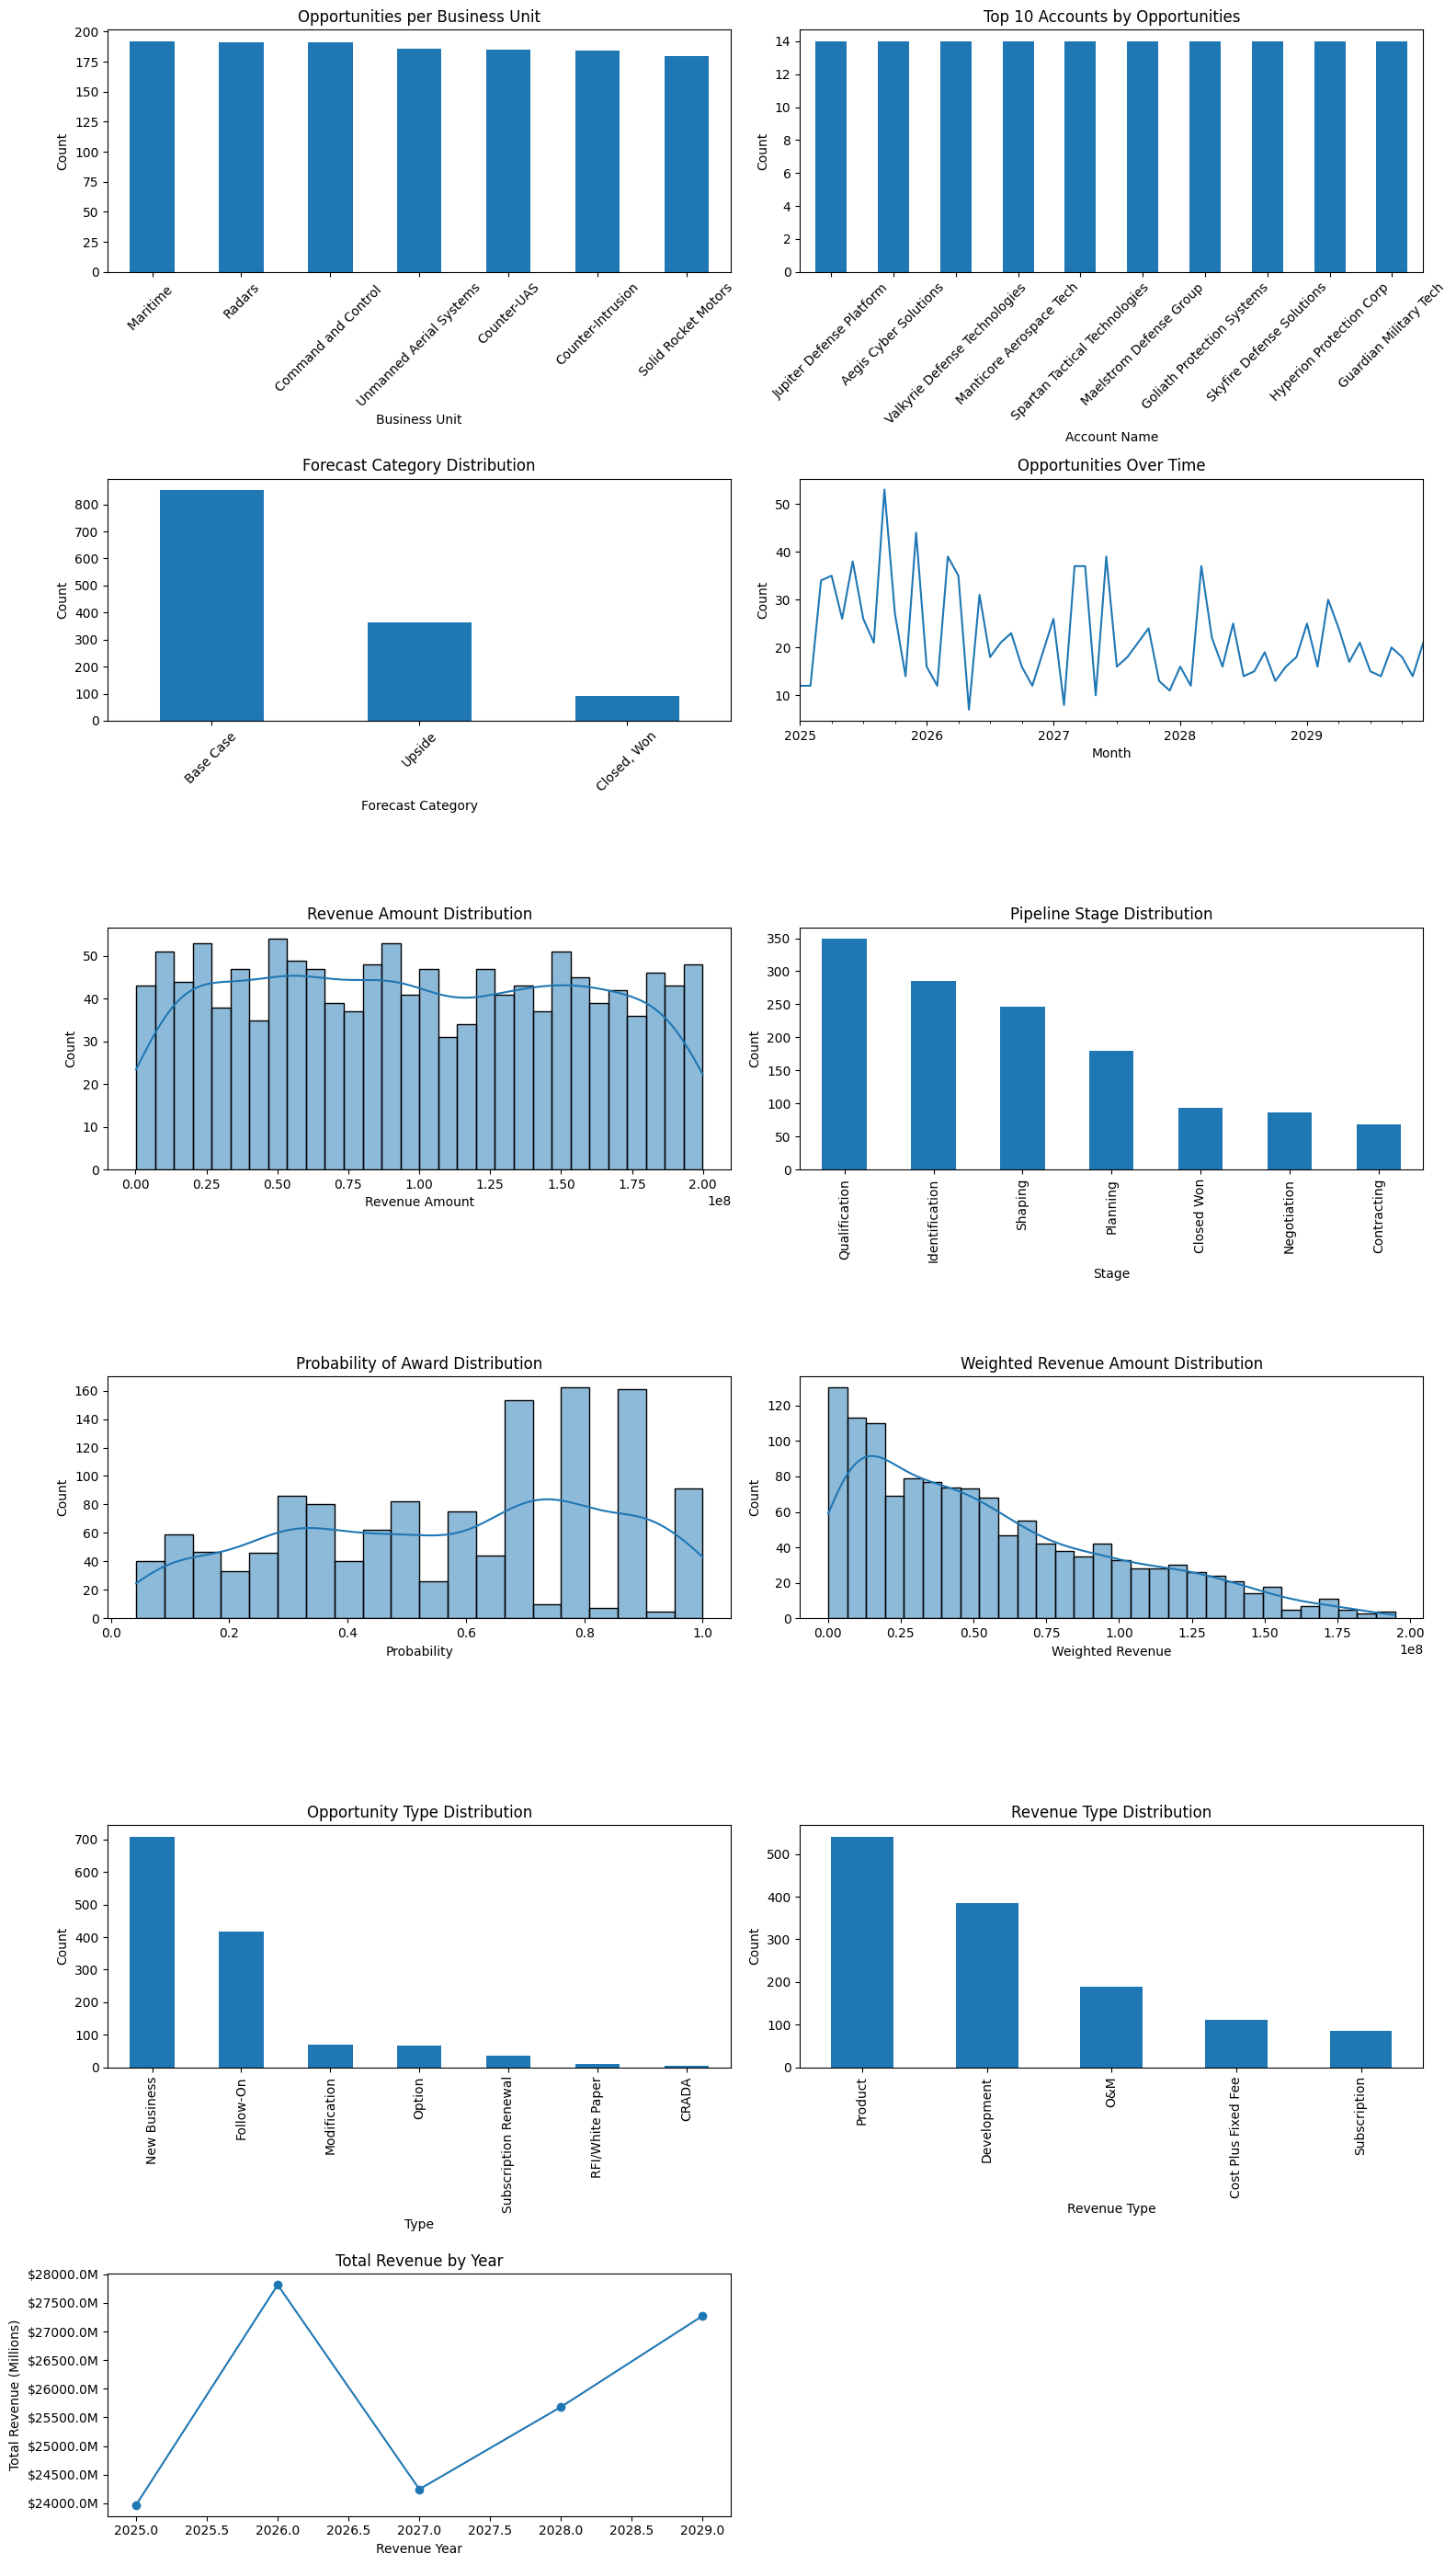

In [206]:
plt.figure(figsize=(16, 28))

# 1. business_unit - Count of opportunities
plt.subplot(6, 2, 1)
df['business_unit'].value_counts().plot(kind='bar')
plt.title("Opportunities per Business Unit")
plt.xlabel("Business Unit")
plt.ylabel("Count")
plt.xticks(rotation=45)

# 2. account_name - Top 10 accounts by opportunity count
plt.subplot(6, 2, 2)
df['account_name'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Accounts by Opportunities")
plt.xlabel("Account Name")
plt.ylabel("Count")
plt.xticks(rotation=45)

# 3. forecast_category - Distribution
plt.subplot(6, 2, 3)
df['forecast_category'].value_counts().plot(kind='bar')
plt.title("Forecast Category Distribution")
plt.xlabel("Forecast Category")
plt.ylabel("Count")
plt.xticks(rotation=45)

# 4. award_date - Opportunities over time
plt.subplot(6, 2, 4)
df['award_date'].dt.to_period("M").value_counts().sort_index().plot()
plt.title("Opportunities Over Time")
plt.xlabel("Month")
plt.ylabel("Count")

# 5. revenue_amount - Distribution
plt.subplot(6, 2, 5)
sns.histplot(df['revenue_amount'], bins=30, kde=True)
plt.title("Revenue Amount Distribution")
plt.xlabel("Revenue Amount")

# 6. stage - Count by stage
plt.subplot(6, 2, 6)
df['stage'].value_counts().plot(kind='bar')
plt.title("Pipeline Stage Distribution")
plt.xlabel("Stage")
plt.ylabel("Count")

# 7. probability_of_award - Distribution
plt.subplot(6, 2, 7)
sns.histplot(df['probability_of_award'], bins=20, kde=True)
plt.title("Probability of Award Distribution")
plt.xlabel("Probability")

# 8. weighted_revenue_amount - Distribution
plt.subplot(6, 2, 8)
sns.histplot(df['weighted_revenue_amount'], bins=30, kde=True)
plt.title("Weighted Revenue Amount Distribution")
plt.xlabel("Weighted Revenue")

# 9. type - Distribution
plt.subplot(6, 2, 9)
df['type'].value_counts().plot(kind='bar')
plt.title("Opportunity Type Distribution")
plt.xlabel("Type")
plt.ylabel("Count")

# 10. revenue_type - Distribution
plt.subplot(6, 2, 10)
df['revenue_type'].value_counts().plot(kind='bar')
plt.title("Revenue Type Distribution")
plt.xlabel("Revenue Type")
plt.ylabel("Count")

# 11. revenue_year - Revenue per year in millions
plt.subplot(6, 2, 11)
ax = df.groupby("revenue_year")["revenue_amount"].sum().plot(marker='o')
plt.title("Total Revenue by Year")
plt.xlabel("Revenue Year")
plt.ylabel("Total Revenue (Millions)")

# Format y-axis ticks as millions
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

# Finish up Feature Engineering (after plotting)

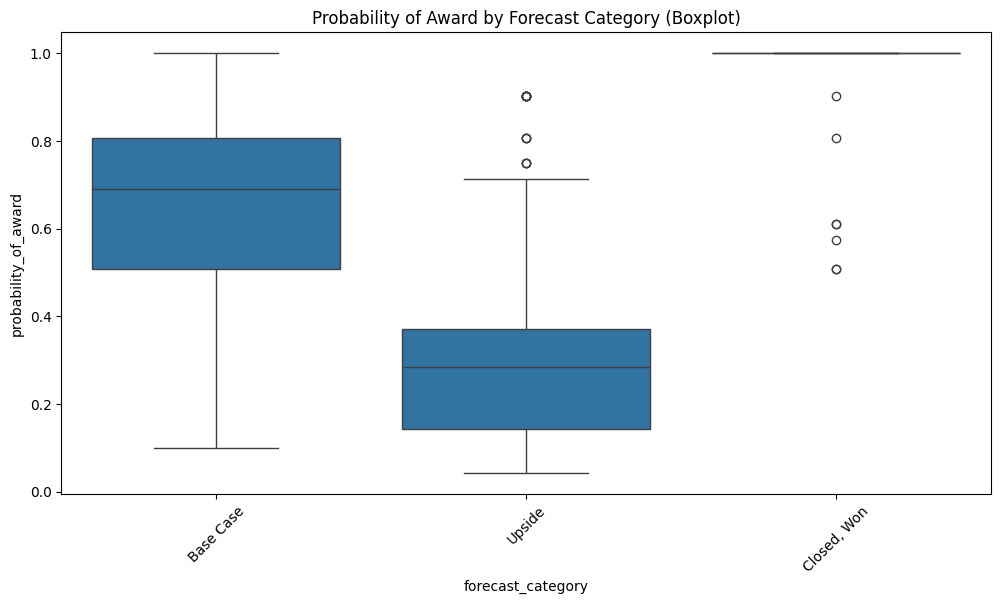

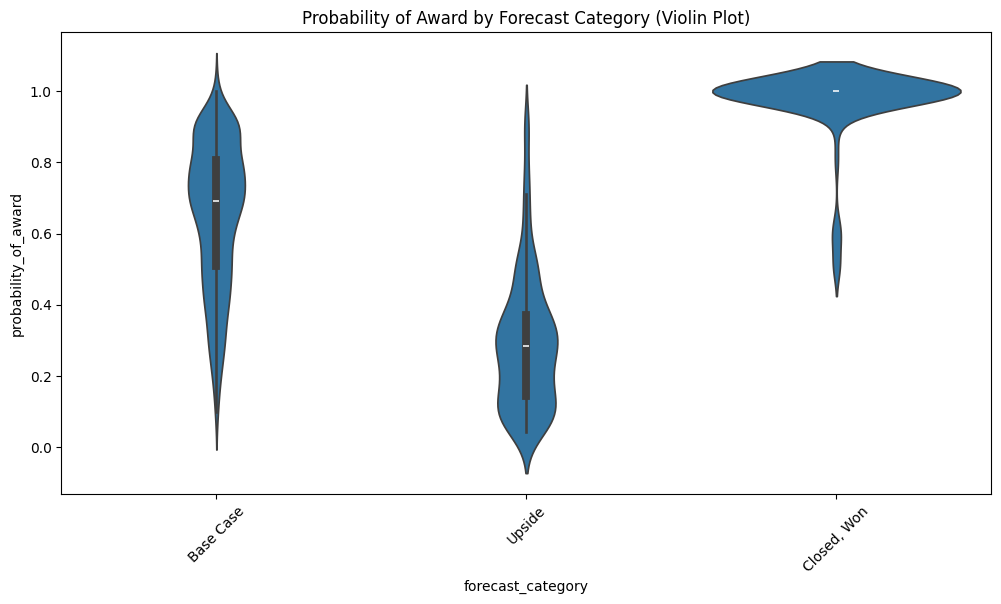

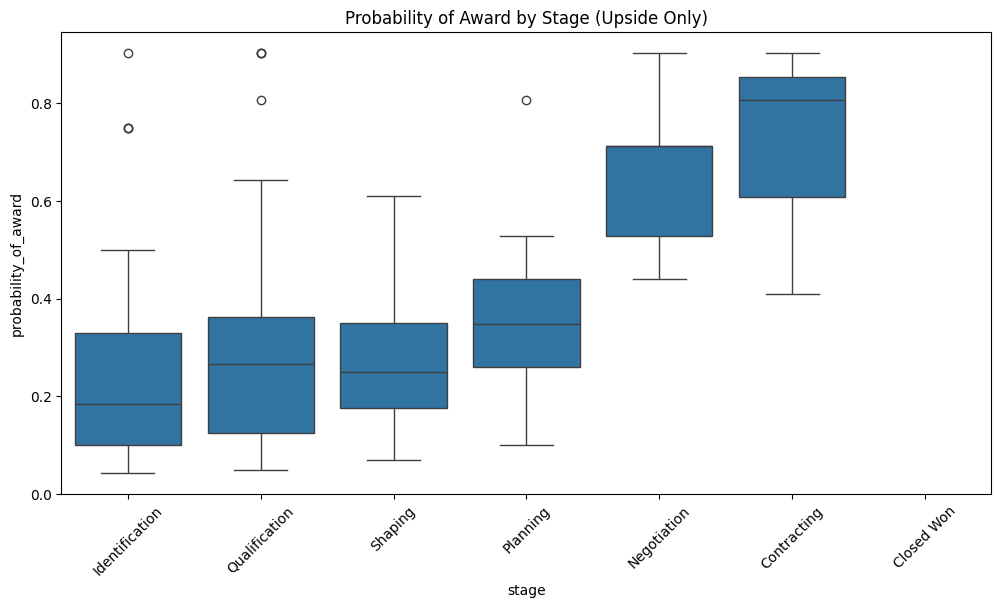

Summary statistics by Forecast Category:
                   count      mean      std     min     25%     50%     75%  \
forecast_category                                                             
Base Case          853.0  0.652057  0.20564  0.1000  0.5075  0.6912  0.8073   
Closed, Won         91.0  0.972742  0.10269  0.5075  1.0000  1.0000  1.0000   
Upside             365.0  0.290609  0.18781  0.0425  0.1435  0.2846  0.3721   

                      max  
forecast_category          
Base Case          1.0000  
Closed, Won        1.0000  
Upside             0.9023  

ANOVA Test Results:
F-statistic: 642.0062, p-value: 0.0000
-> There are statistically significant differences between the forecast categories.


In [207]:
# Set ordered category for 'stage'
stage_order = [
    'Identification', 'Qualification', 'Shaping', 'Planning',
    'Negotiation', 'Contracting', 'Closed Won'
]
df['stage'] = pd.Categorical(df['stage'], categories=stage_order, ordered=True)

# Plot: Probability of Award by Forecast Category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='forecast_category', y='probability_of_award')
plt.title('Probability of Award by Forecast Category (Boxplot)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='forecast_category', y='probability_of_award')
plt.title('Probability of Award by Forecast Category (Violin Plot)')
plt.xticks(rotation=45)
plt.show()

# Extra: Probability of Award by Stage for Upside deals
upside_df = df[df['forecast_category'] == 'Upside']

plt.figure(figsize=(12, 6))
sns.boxplot(data=upside_df, x='stage', y='probability_of_award')
plt.title('Probability of Award by Stage (Upside Only)')
plt.xticks(rotation=45)
plt.show()

# Summary Stats
print("Summary statistics by Forecast Category:")
summary_stats = df.groupby('forecast_category')['probability_of_award'].describe()
print(summary_stats)

# ANOVA Test
groups = [group['probability_of_award'].values for name, group in df.groupby('forecast_category')]
anova_result = f_oneway(*groups)
print("\nANOVA Test Results:")
print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4f}")

if anova_result.pvalue < 0.05:
    print("-> There are statistically significant differences between the forecast categories.")
else:
    print("-> No significant differences detected.")


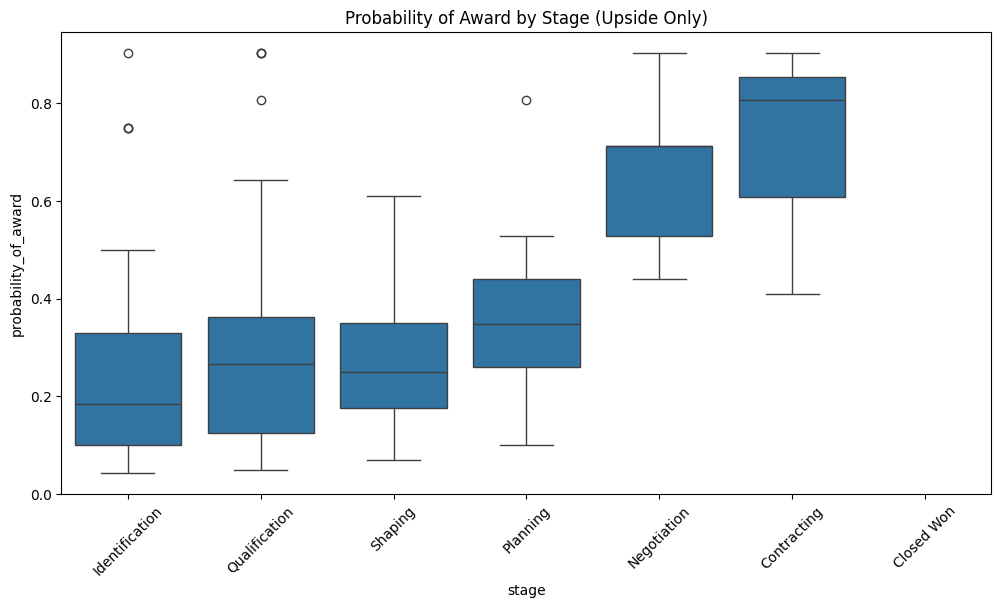

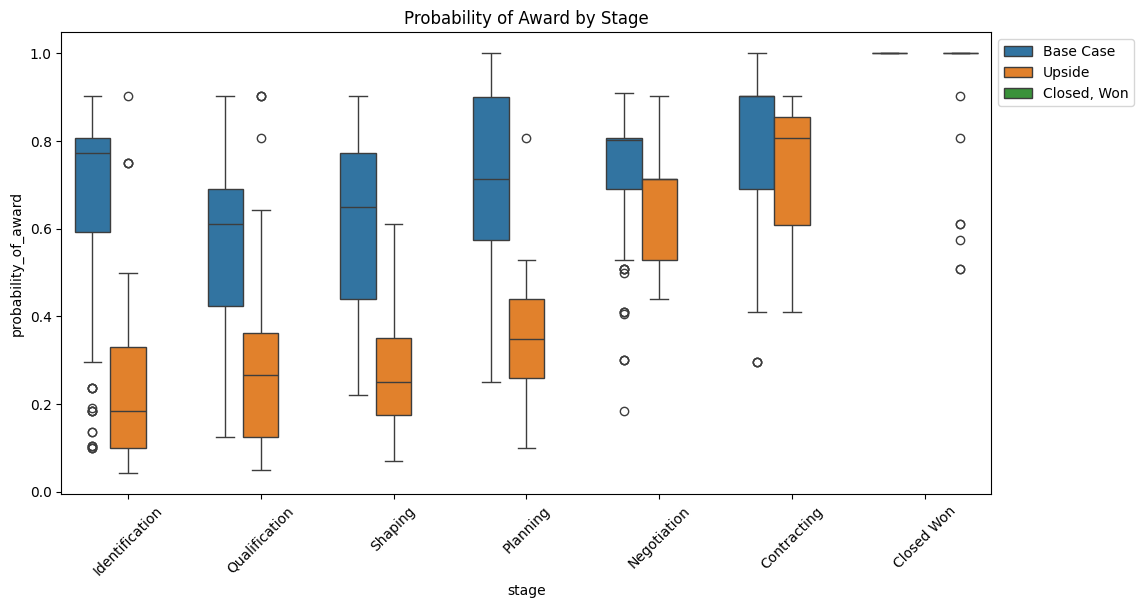

In [208]:
# Extra: Probability of Award by Stage for Upside deals
upside_df = df[df['forecast_category'] == 'Upside']

plt.figure(figsize=(12, 6))
sns.boxplot(data=upside_df, x='stage', y='probability_of_award')
plt.title('Probability of Award by Stage (Upside Only)')
plt.xticks(rotation=45)
plt.show()

# Make this plot again, but for "Base Case" and "Closed, Won" as well
base_case_df = df[df['forecast_category'] == 'Base Case']
closed_won_df = df[df['forecast_category'] == 'Closed, Won']
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='stage', y='probability_of_award', hue='forecast_category')
plt.title('Probability of Award by Stage')
plt.xticks(rotation=45)
plt.legend(title='Forecast Category')
# Move rthe legend to the top left
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [209]:
# Why isn't Closed, Won in the plot?
print(df['forecast_category'].value_counts(dropna=False))
print(closed_won_df['stage'].value_counts(dropna=False))

forecast_category
Base Case      853
Upside         365
Closed, Won     91
Name: count, dtype: Int64
stage
Closed Won        91
Identification     0
Qualification      0
Shaping            0
Planning           0
Negotiation        0
Contracting        0
Name: count, dtype: int64


In [210]:
# Check value counts for probability_of_award when `forecast_category` is Closed, Won and `stage` is Closed Won

# print(closed_won_df[closed_won_df['stage'] == 'Closed Won']['probability_of_award'].value_counts(dropna=False))

# Loop over each stage and get the value counts for probability_of_award
for stage in df['stage'].unique():
    print(f"Stage: {stage}")
    print(df[df['stage'] == stage]['probability_of_award'].value_counts(dropna=False))
    print("\n")

Stage: Shaping
probability_of_award
0.9023    19
0.6912    18
0.2970    16
0.7725    15
0.4398    14
          ..
0.3000     1
0.3700     1
0.4800     1
0.1350     1
0.2100     1
Name: count, Length: 54, dtype: int64


Stage: Qualification
probability_of_award
0.6912    33
0.3510    20
0.7725    19
0.2970    19
0.6099    18
          ..
0.3724     1
0.1913     1
0.1845     1
0.3553     1
0.0615     1
Name: count, Length: 60, dtype: int64


Stage: Planning
probability_of_award
0.9023    35
0.7124    21
0.8073    11
0.5075    11
0.6099    10
          ..
0.4050     1
0.8000     1
0.7000     1
0.6500     1
0.1500     1
Name: count, Length: 46, dtype: int64


Stage: Negotiation
probability_of_award
0.8073    18
0.9023    12
0.7124     8
0.7725     7
0.6912     6
          ..
0.1845     1
0.6099     1
0.4398     1
0.5000     1
0.9100     1
Name: count, Length: 21, dtype: int64


Stage: Identification
probability_of_award
0.9023    39
0.7725    28
0.8073    23
0.6912    16
0.1000    16
     

/var/folders/xy/8hvrs8m970qgw74212qdv2g00000gn/T/ipykernel_2434/2545836300.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Forecast Category')
/var/folders/xy/8hvrs8m970qgw74212qdv2g00000gn/T/ipykernel_2434/2545836300.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


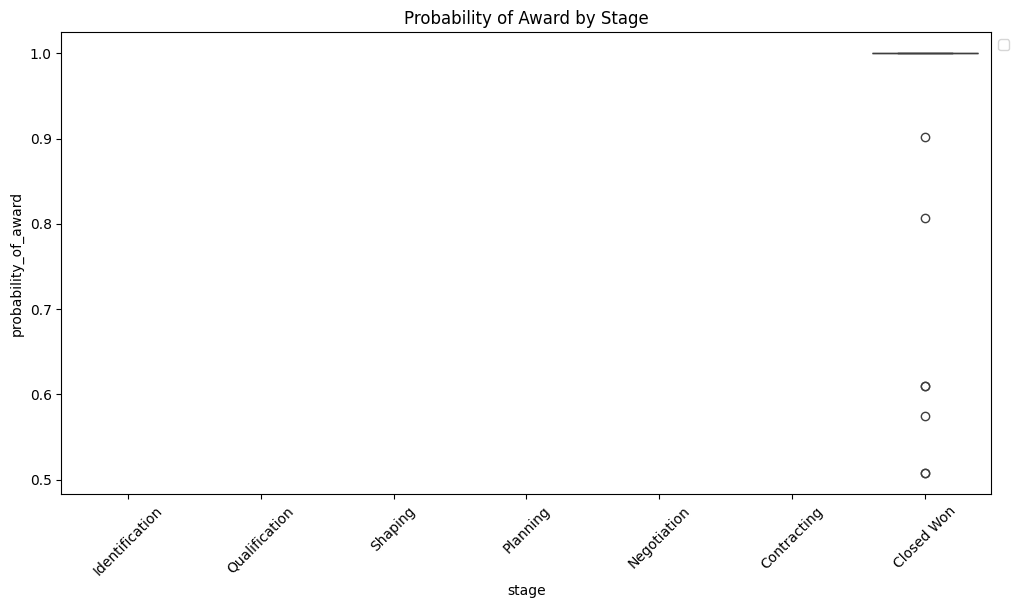

In [211]:
# closed_won_df = df[df['forecast_category'] == 'Closed, Won']
plt.figure(figsize=(12, 6))
sns.boxplot(data=closed_won_df, x='stage', y='probability_of_award')
plt.title('Probability of Award by Stage')
plt.xticks(rotation=45)
plt.legend(title='Forecast Category')
# Move rthe legend to the top left
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()

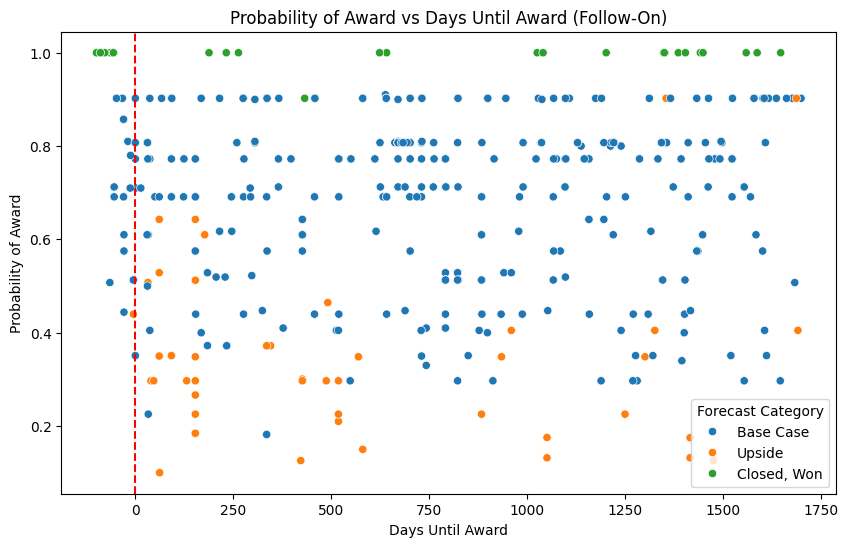

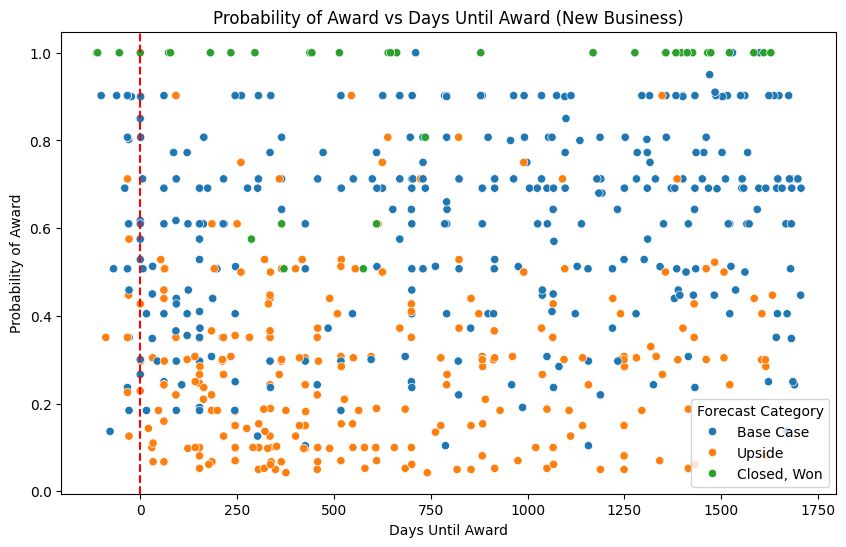

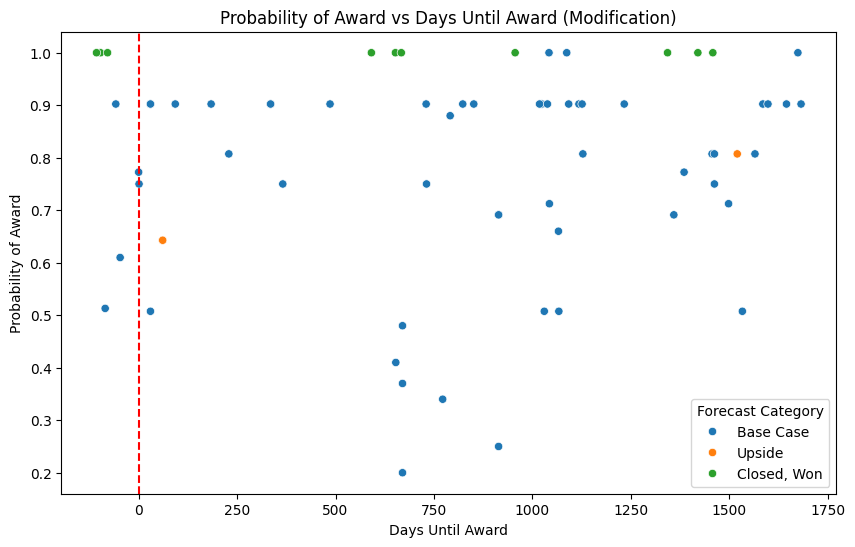

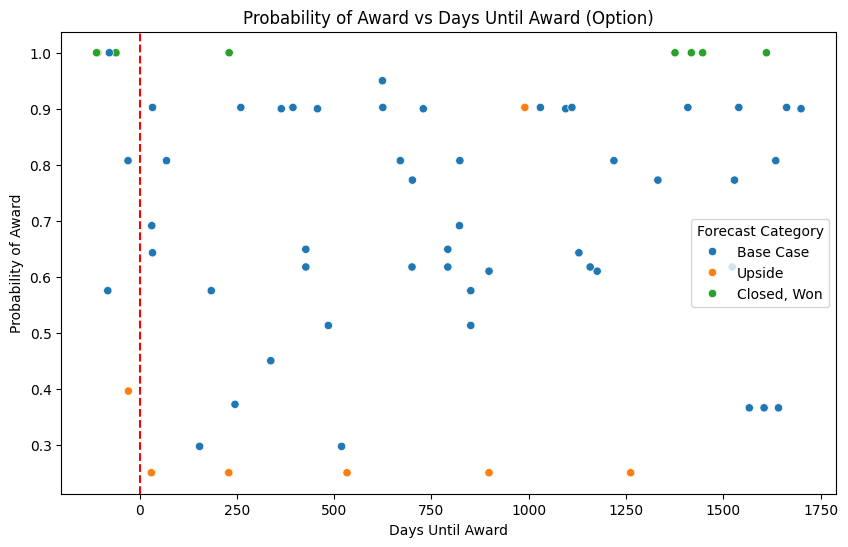

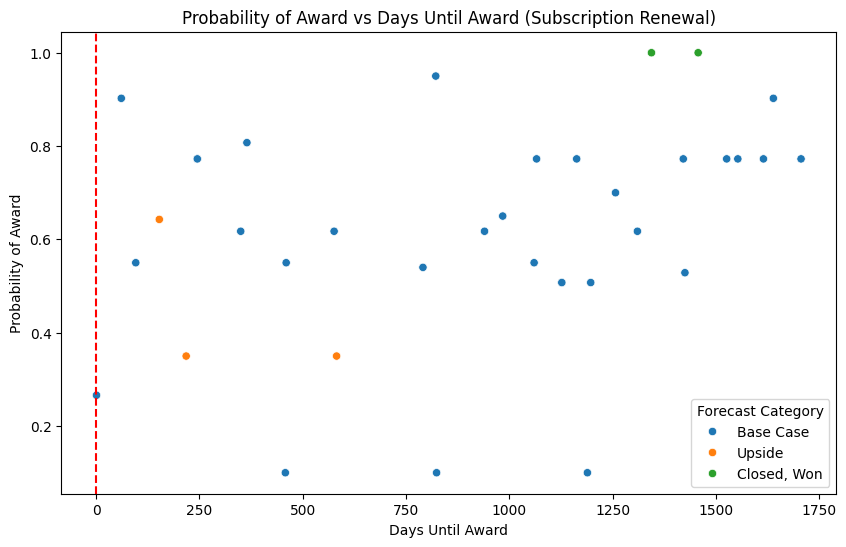

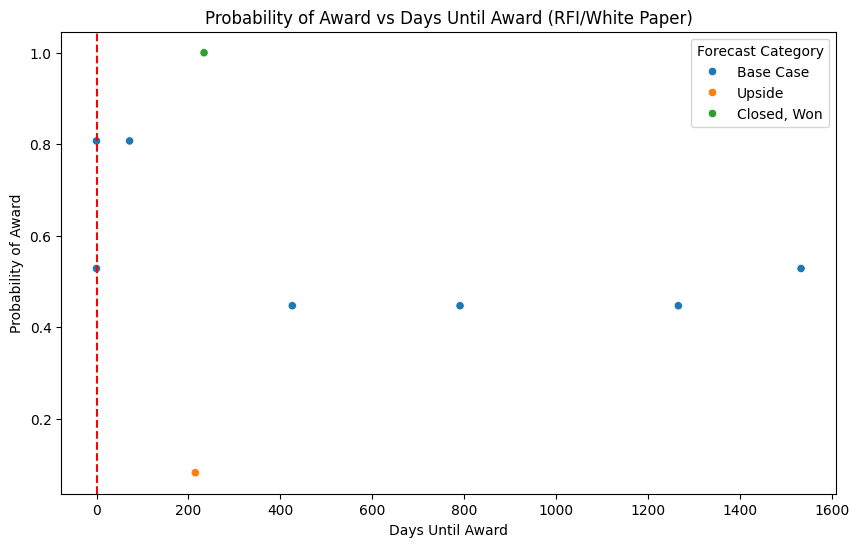

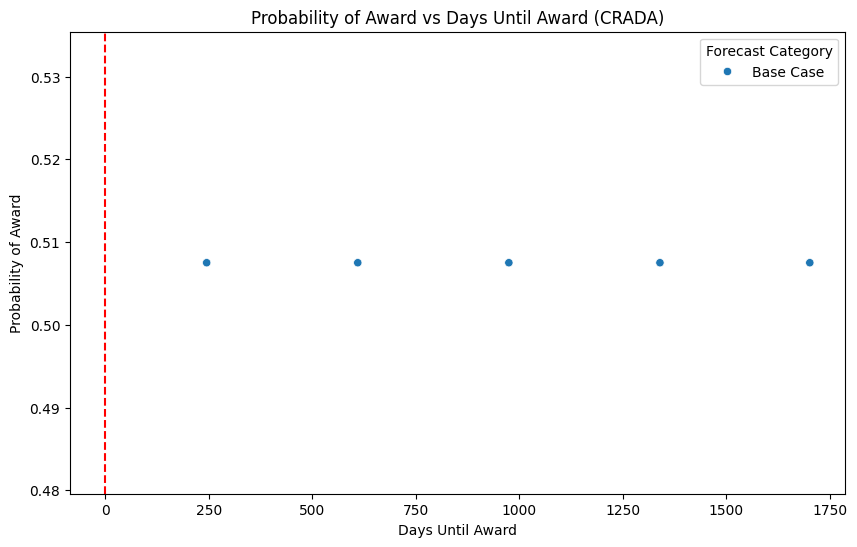

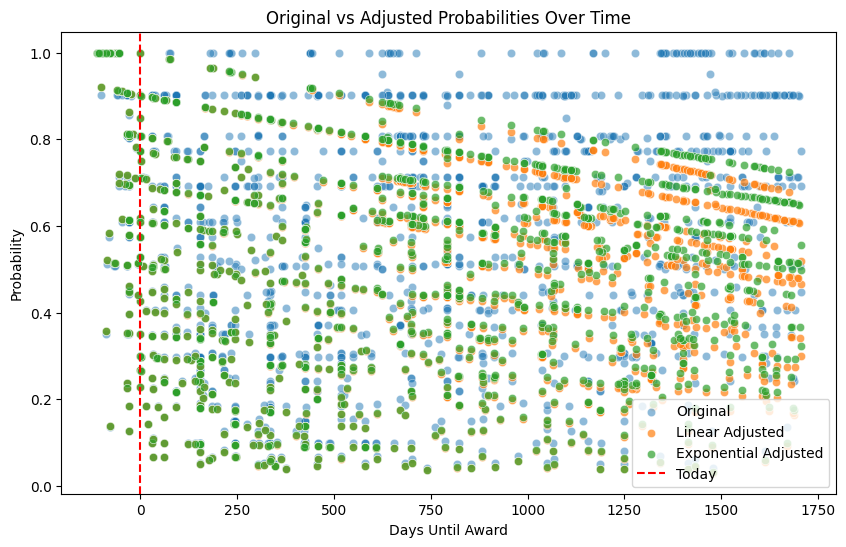

In [212]:
# Create days_until_award
df['days_until_award'] = (df['award_date'] - pd.Timestamp.now()).dt.days

# Set ordered category for 'stage'
stage_order = [
    'Identification', 'Qualification', 'Shaping', 'Planning',
    'Negotiation', 'Contracting', 'Closed, Won'
]
df['stage'] = pd.Categorical(df['stage'], categories=stage_order, ordered=True)

# ---- Plot: Days Until Award vs Probability, for each Type separately ----
types = df['type'].dropna().unique()

for t in types:
    subset = df[df['type'] == t]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=subset, x='days_until_award', y='probability_of_award', hue='forecast_category')
    plt.title(f'Probability of Award vs Days Until Award ({t})')
    plt.xlabel('Days Until Award')
    plt.ylabel('Probability of Award')
    plt.legend(title='Forecast Category')
    plt.axvline(x=0, color='red', linestyle='--', label='Today')
    plt.show()

# ---- Add Adjusted Probabilities ----
alpha = 0.07  # linear decay per year
beta = 0.07   # exponential decay per year

def adjust_probability_linear(probability, days_until_award):
    years = days_until_award / 365
    adjusted = probability * (1 - alpha * years)
    return max(min(adjusted, 1.0), 0.0)

def adjust_probability_exponential(probability, days_until_award):
    years = days_until_award / 365
    adjusted = probability * np.exp(-beta * years)
    return max(min(adjusted, 1.0), 0.0)

df['probability_of_award_linear'] = df.apply(lambda row: adjust_probability_linear(row['probability_of_award'], row['days_until_award']), axis=1)
df['probability_of_award_exponential'] = df.apply(lambda row: adjust_probability_exponential(row['probability_of_award'], row['days_until_award']), axis=1)

# ---- Plot: Compare Original vs Adjusted Probability ----
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='days_until_award', y='probability_of_award', label='Original', alpha=0.5)
sns.scatterplot(data=df, x='days_until_award', y='probability_of_award_linear', label='Linear Adjusted', alpha=0.7)
sns.scatterplot(data=df, x='days_until_award', y='probability_of_award_exponential', label='Exponential Adjusted', alpha=0.7)
plt.title('Original vs Adjusted Probabilities Over Time')
plt.xlabel('Days Until Award')
plt.ylabel('Probability')
plt.axvline(x=0, color='red', linestyle='--', label='Today')
plt.legend()
plt.show()


In [213]:
# Add a variable for how many rows have already been awarded ie. days_until_award <= 0
df['awarded'] = df['days_until_award'] <= 0
print(df['awarded'].value_counts(dropna=False))

# Group by this and year to see how much revenue has been awarded
awarded_revenue = df.groupby(['revenue_year', 'awarded'])['revenue_amount'].sum().reset_index()
print(awarded_revenue)

# Remove scientific notation and show with _ or ,
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

awarded
False    1216
True       93
Name: count, dtype: int64
   revenue_year  awarded  revenue_amount
0          2025    False    1.943060e+10
1          2025     True    4.537667e+09
2          2026    False    2.781550e+10
3          2027    False    2.424394e+10
4          2028    False    2.568297e+10
5          2029    False    2.713280e+10
6          2029     True    1.428821e+08


In [214]:
# How is there rows with awarded = True but in 2029?

# Find rows where award_date is in the past but revenue_year is in the future
reqs = (
    (df['award_date'] < pd.Timestamp.now()) &
    (df['revenue_year'] > pd.Timestamp.now().year)
)
print(df[reqs].shape)
df[reqs]

(1, 16)


,business_unit,account_name,opportunity_number,forecast_category,award_date,revenue_amount,stage,probability_of_award,weighted_revenue_amount,type,revenue_type,revenue_year,days_until_award,probability_of_award_linear,probability_of_award_exponential,awarded
606,Maritime,Nightshade Security Ops,23244,Base Case,2025-03-28,"142,882,077.00",Planning,0.90,"128,922,498.08",New Business,Cost Plus Fixed Fee,2029,-33,0.91,0.91,True


In [215]:
# Why isn't `revenue_amount` * `probability_of_award` equal to `weighted_revenue_amount`?
# Wait nvm I had pd.options display.float_format set to no decimals duh

for row in df[reqs].itertuples():
    print(f"Row {row.Index}:")
    print(f"  revenue_amount: {row.revenue_amount}")
    print(f"  probability_of_award: {row.probability_of_award}")
    print(f"  weighted_revenue_amount: {row.weighted_revenue_amount}")
    print(f"  award_date: {row.award_date}")
    print(f"  revenue_year: {row.revenue_year}")
    assert row.revenue_amount * row.probability_of_award == row.weighted_revenue_amount, "Mismatch in weighted revenue amount"  
    print()

Row 606:
  revenue_amount: 142882077.0
  probability_of_award: 0.9023
  weighted_revenue_amount: 128922498.0771
  award_date: 2025-03-28 00:00:00
  revenue_year: 2029



In [216]:
# This method is decaying low probabilities to 0 as well, so delete both columsn and we try something new
del df['probability_of_award_linear']
del df['probability_of_award_exponential']

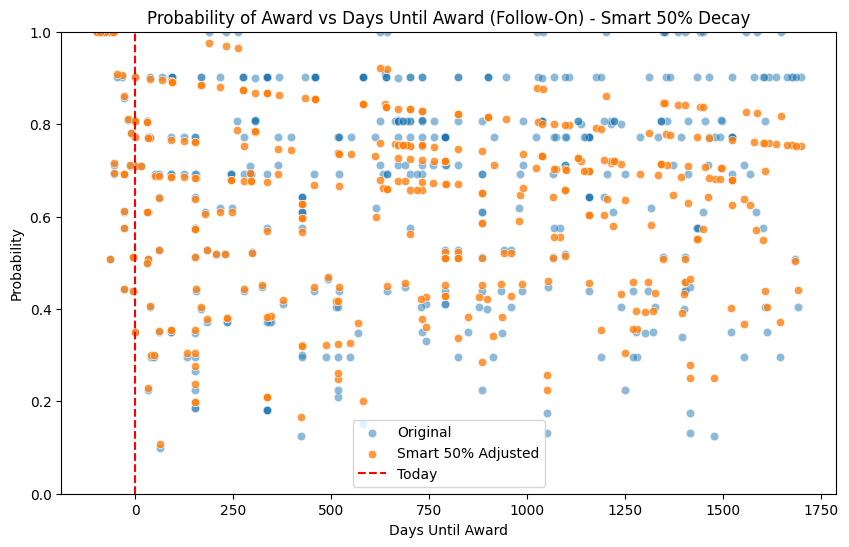

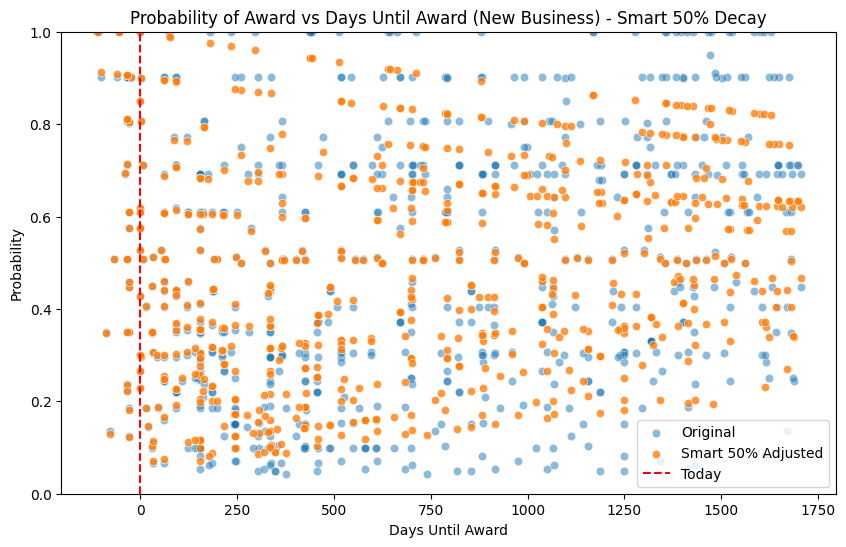

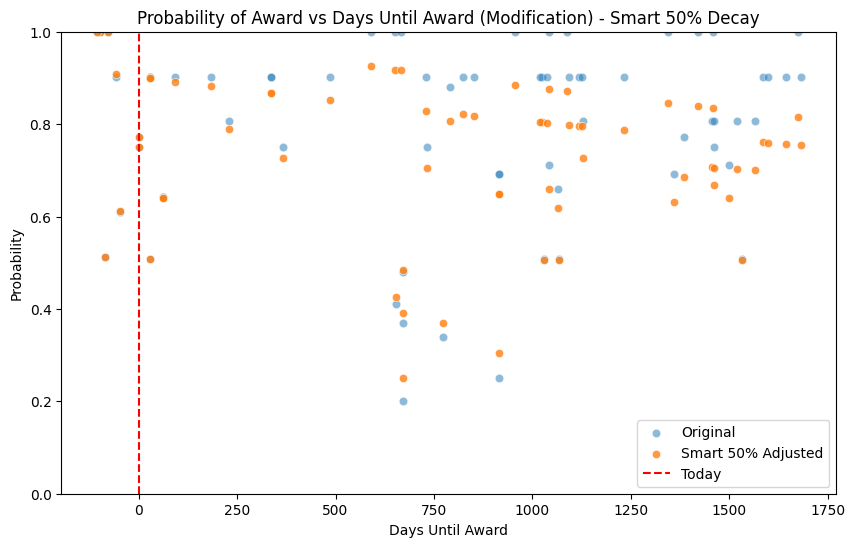

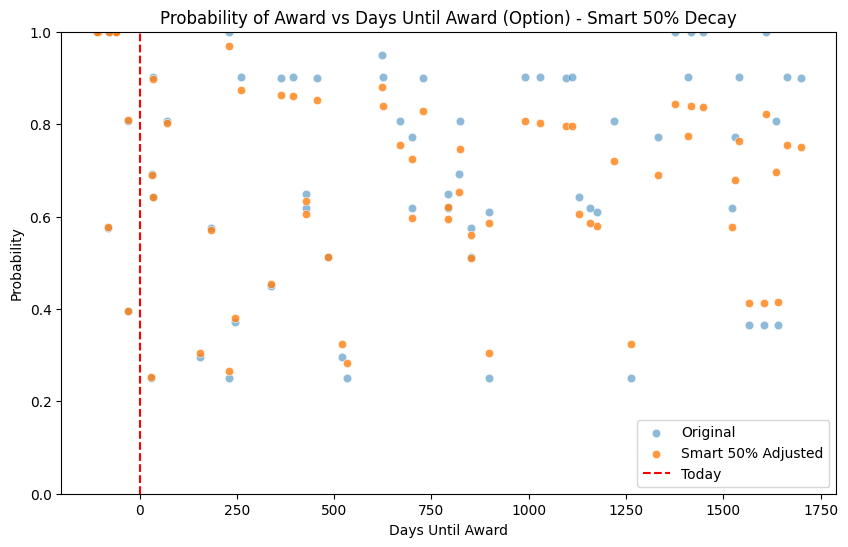

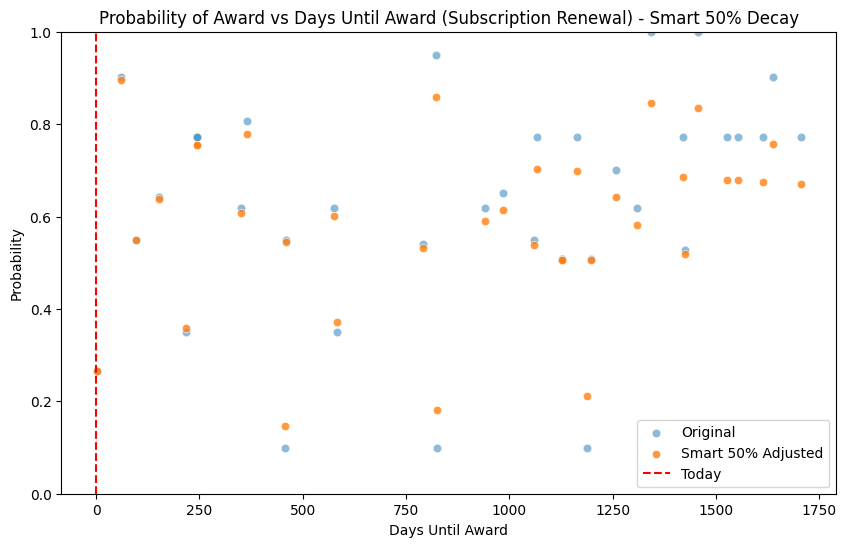

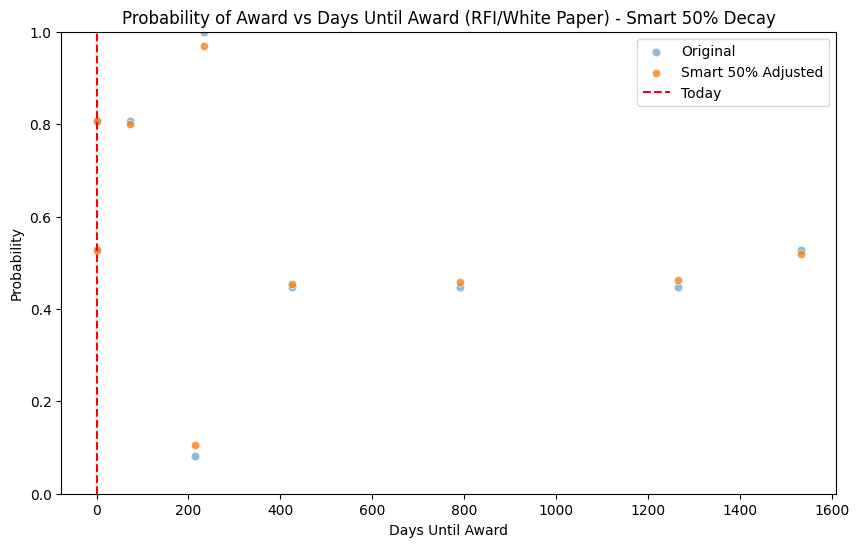

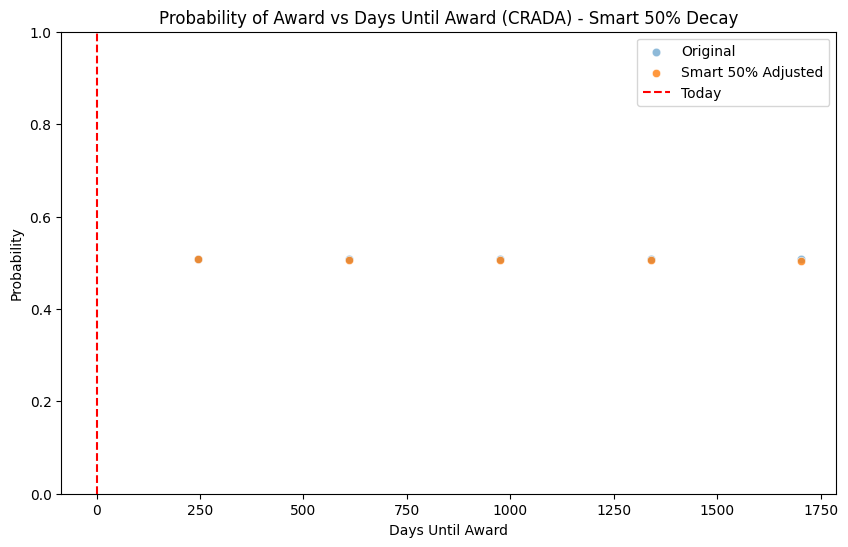

In [217]:
# ---- Smart 50% Convergence Adjustment ----
gamma = 0.1  # speed of convergence (you can tune this)

def adjust_probability_smart50(probability, days_until_award):
    years = days_until_award / 365
    decay_factor = 1 - np.exp(-gamma * years)
    adjusted = probability + (0.5 - probability) * decay_factor
    return max(min(adjusted, 1.0), 0.0)

# Apply it
df['probability_of_award_smart50'] = df.apply(lambda row: adjust_probability_smart50(row['probability_of_award'], row['days_until_award']), axis=1)

# ---- Plotting: Smart 50% Decay Only ----
types = df['type'].dropna().unique()

for t in types:
    subset = df[df['type'] == t]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=subset, x='days_until_award', y='probability_of_award', label='Original', alpha=0.5)
    sns.scatterplot(data=subset, x='days_until_award', y='probability_of_award_smart50', label='Smart 50% Adjusted', alpha=0.8)
    plt.title(f'Probability of Award vs Days Until Award ({t}) - Smart 50% Decay')
    plt.xlabel('Days Until Award')
    plt.ylabel('Probability')
    plt.axvline(x=0, color='red', linestyle='--', label='Today')
    plt.legend()
    # For your sanity, set y axis to 0-1
    plt.ylim(0, 1)
    plt.show()

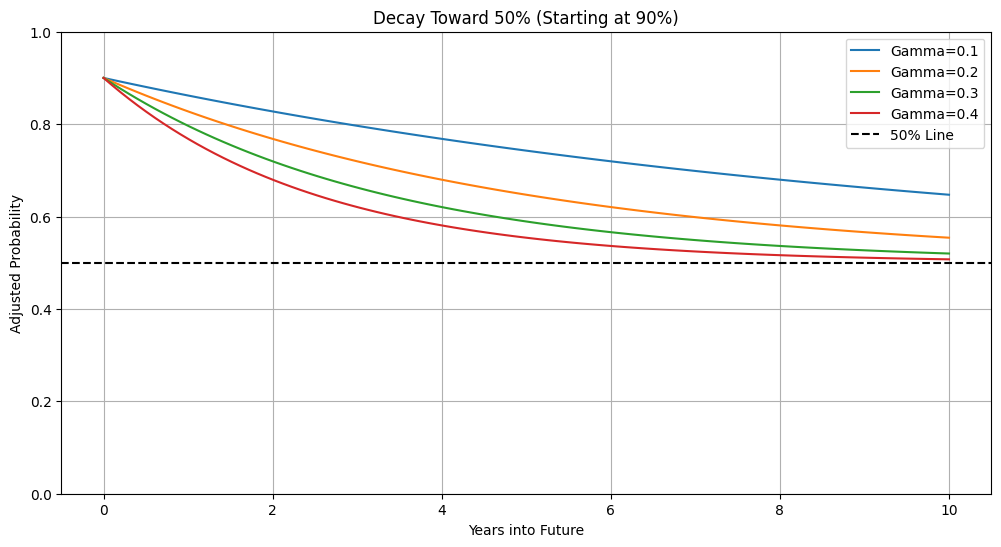

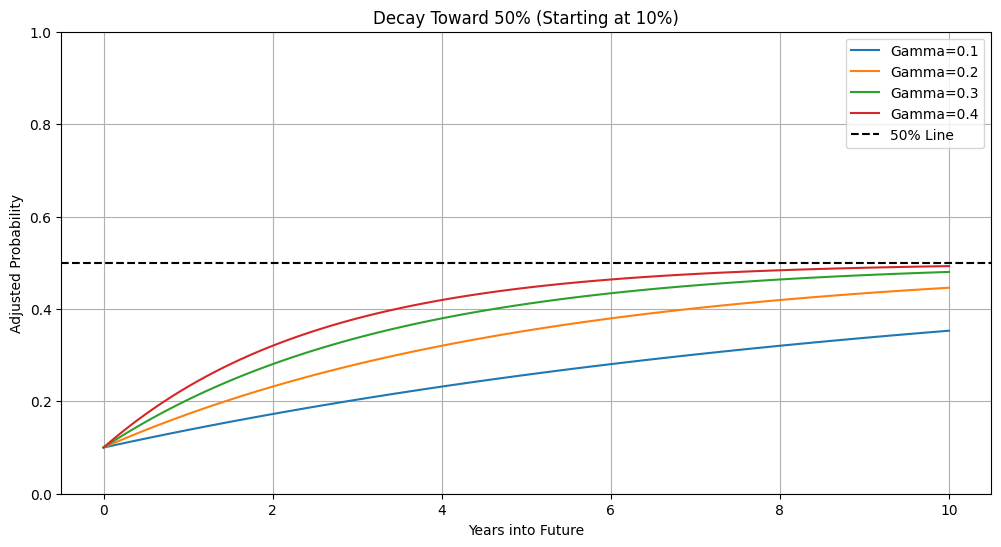

In [218]:
# Example - showing how gamma affects the decay

# Define years
years = np.linspace(0, 10, 100)

# Different gamma values
gammas = [0.1, 0.2, 0.3, 0.4]

# Example starting probabilities
start_probs = [0.9, 0.1]  # 90% and 10%

# Smart 50% decay function
def smart50(prob, years, gamma):
    decay_factor = 1 - np.exp(-gamma * years)
    adjusted = prob + (0.5 - prob) * decay_factor
    return adjusted

# Plot for 90% starting probability
plt.figure(figsize=(12, 6))
for gamma in gammas:
    adjusted = smart50(0.9, years, gamma)
    plt.plot(years, adjusted, label=f'Gamma={gamma}')
plt.axhline(0.5, color='black', linestyle='--', label='50% Line')
plt.title('Decay Toward 50% (Starting at 90%)')
plt.xlabel('Years into Future')
plt.ylabel('Adjusted Probability')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

# Plot for 10% starting probability
plt.figure(figsize=(12, 6))
for gamma in gammas:
    adjusted = smart50(0.1, years, gamma)
    plt.plot(years, adjusted, label=f'Gamma={gamma}')
plt.axhline(0.5, color='black', linestyle='--', label='50% Line')
plt.title('Decay Toward 50% (Starting at 10%)')
plt.xlabel('Years into Future')
plt.ylabel('Adjusted Probability')
plt.legend()
plt.grid(True)
# For y-axis sanity, set limits to 0-1
plt.ylim(0, 1)
plt.show()


In [219]:
# If awarded, set probability to 1
grouped = df.groupby(['revenue_year', 'awarded'])['probability_of_award_smart50'].mean().reset_index()
print(" --- Before setting awarded to 1 -------")
print(grouped)

df.loc[df['awarded'], 'probability_of_award_smart50'] = 1.0
print(" --- After setting awarded to 1 -------")
grouped = df.groupby(['revenue_year', 'awarded'])['probability_of_award_smart50'].mean().reset_index()
print(grouped)

 --- Before setting awarded to 1 -------
   revenue_year  awarded  probability_of_award_smart50
0          2025    False                          0.47
1          2025     True                          0.70
2          2026    False                          0.49
3          2027    False                          0.59
4          2028    False                          0.56
5          2029    False                          0.63
6          2029     True                          0.91
 --- After setting awarded to 1 -------
   revenue_year  awarded  probability_of_award_smart50
0          2025    False                          0.47
1          2025     True                          1.00
2          2026    False                          0.49
3          2027    False                          0.59
4          2028    False                          0.56
5          2029    False                          0.63
6          2029     True                          1.00


In [220]:
# Using the new probability, calculate the weighted revenue amount
df['weighted_revenue_amount_smart50'] = df['revenue_amount'] * df['probability_of_award_smart50']
print(df['weighted_revenue_amount_smart50'].describe())

# Group by revenue year
print(" --- Grouped by revenue year -------")
grouped = df.groupby(['revenue_year', ])['weighted_revenue_amount_smart50'].sum().reset_index()
print(grouped)

count         1,309.00
mean     55,233,135.35
std      40,014,001.18
min          95,488.80
25%      21,017,348.37
50%      48,851,408.39
75%      84,619,625.55
max     196,273,853.00
Name: weighted_revenue_amount_smart50, dtype: float64
 --- Grouped by revenue year -------
   revenue_year  weighted_revenue_amount_smart50
0          2025                12,003,319,307.95
1          2026                13,702,476,548.42
2          2027                14,376,754,521.83
3          2028                14,794,556,670.33
4          2029                17,423,067,122.74


# Export Data

In [221]:
# Write down dtypes so you can just read them in later like this
print(df.dtypes)

business_unit                      string[python]
account_name                       string[python]
opportunity_number                          int64
forecast_category                  string[python]
award_date                         datetime64[ns]
revenue_amount                            float64
stage                                    category
probability_of_award                      float64
weighted_revenue_amount                   float64
type                               string[python]
revenue_type                       string[python]
revenue_year                                int64
days_until_award                            int64
awarded                                      bool
probability_of_award_smart50              float64
weighted_revenue_amount_smart50           float64
dtype: object


In [222]:
# Export to a CSV for use in other notebooks
clean_data_path = base_path / config["paths"]["clean_data"]
df.to_csv(clean_data_path / config["data"]["clean"]["path"], index=False)

print(f"Data Cleaned and Exported to {clean_data_path / config['data']['clean']['path']}")

Data Cleaned and Exported to ../data/01_clean/20250423_cleaned_data.csv


In [223]:
# Stop timer
timer.stop()

Elapsed time: 0 minutes and 2 seconds
